In [1]:
import copy
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, List, Literal, Set, Tuple

import matplotlib
import matplotlib.colors
import numpy as np
import einops
import torch

import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


In [2]:
from dataset.construct import ImageDataset


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


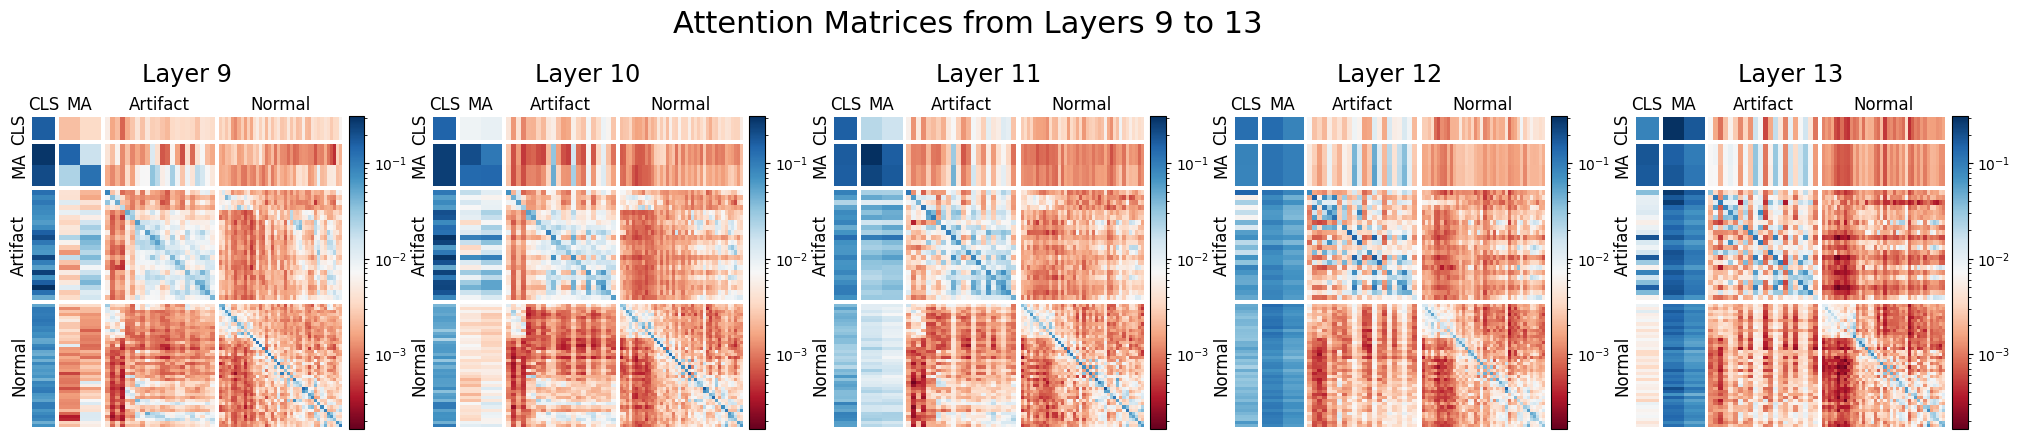

In [4]:
from core.monitor import Monitor
from core.attention_sink import mask_attention_sink
from modeling.vit_attention import OpenCLIPAttentionViT
from visualize.attention import visualize_attention_matrix_per_image, visualize_attention_matrix_per_layer


MA_mask: torch.Tensor = torch.load(f"experiments/saved_masks/MA_mask{batch_size}.pt", map_location=DEVICE)
AS_mask: torch.Tensor = torch.load(f"experiments/saved_masks/ranked_AS_mask{batch_size}.pt", map_location=DEVICE).isfinite()
mta_masks: Dict[int, torch.Tensor] = {
    "MA": MA_mask,
    "Artifact": AS_mask * ~MA_mask,
}

def mean_attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.mean(einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ), dim=-1)

attention_matrix_monitor_config = OrderedDict({
    "model.visual.transformer.resblocks.attn.return_attn_matrix": [
        ("attention_matrix", mean_attention_matrix_hook_fn),
    ],
})

baseline_model = OpenCLIPAttentionViT({})
monitor = Monitor(baseline_model, attention_matrix_monitor_config, device=DEVICE)
log = monitor.reset()
with torch.no_grad():
    baseline_model.forward(images)
attention_matrices = torch.stack([t[0] for t in log["attention_matrix"]], dim=0)


# for layer_idx in range(6, 14):
#     visualize_attention_matrix_per_image(
#         layer_idx, attention_matrices[layer_idx], mta_masks, per_head=False,
#         rescale_func=lambda t: torch.log2(t + 1), subsample=1.0, global_cmap=False, cmap="viridis",    # cmap_scale="arcsinh",
#     )
visualize_attention_matrix_per_layer(
    [*range(9, 14)], attention_matrices, mta_masks,
    rescale_func=lambda t: torch.log2(t + 1), subsample=0.2, global_cmap=True, cmap="RdBu", cmap_scale="log", save_fname=f"{OUTPUT_DIR}/{EXPERIMENT_DIR}/attention_matrix",
)